<a href="https://colab.research.google.com/github/ariegever/Thesis_SDM/blob/main/SDM_ACCURACY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.0 MB/s eta 0:00:00


In [ ]:
import ee
import rasterio
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import random
from google.colab import drive
drive.mount('/content/drive')
# 1. Initialize
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize(project='cryptic-yen-457008-p4')

Mounted at /content/drive


In [ ]:

# CONFIGURATION

tif_path = '/content/drive/MyDrive/GEE_Exports/avocado_habitat_suitability.tif'

avocado_asset = 'projects/cryptic-yen-457008-p4/assets/avocado_polygons'


# PROCESSING

print("1. Fetching Presence Points from GEE...")
# Load and clean presence points (same logic as before)
grain_size = 1000
data_raw = ee.FeatureCollection(avocado_asset)
random_raster = ee.Image.random().reproject("EPSG:4326", None, grain_size)
rand_point_vals = random_raster.sampleRegions(collection=data_raw, geometries=True)
data_clean = rand_point_vals.distinct("random")

# Extract Coordinate List [[lon, lat], [lon, lat], ...]
# This brings the points from GEE server to your local Python
presence_coords = [f['geometry']['coordinates'] for f in data_clean.getInfo()['features']]
n_presence = len(presence_coords)
print(f"   > Found {n_presence} presence points.")

print("2. Sampling TIFF file locally...")
try:
    with rasterio.open(tif_path) as src:
        # A. Sample Presence Points
        # src.sample expects a list of (x, y) tuples
        pres_vals = [x[0] for x in src.sample(presence_coords)]

        # Filter out NoData values (if points fall outside the map)
        pres_vals = [x for x in pres_vals if x != src.nodata and not np.isnan(x)]

        # B. Generate Pseudo-Absence (Random Background) Points
        # We generate random points within the bounds of your TIFF
        print(f"   > Generating {len(pres_vals)} pseudo-absence points...")
        bounds = src.bounds
        abs_vals = []

        while len(abs_vals) < len(pres_vals):
            # Generate random coord within bounds
            rx = random.uniform(bounds.left, bounds.right)
            ry = random.uniform(bounds.bottom, bounds.top)

            # Sample it
            val_gen = src.sample([(rx, ry)])
            val = next(val_gen)[0]

            # Keep if valid and not NoData
            if val != src.nodata and not np.isnan(val):
                abs_vals.append(val)

        # C. Prepare Data for AUC
        y_true = [1] * len(pres_vals) + [0] * len(abs_vals)
        y_scores = pres_vals + abs_vals

        # 3. Calculate AUC
        # Sort for ROC
        sorted_data = sorted(zip(y_scores, y_true), reverse=True) # Sort by score desc
        y_scores_sorted, y_true_sorted = zip(*sorted_data)

        from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = sk_auc(fpr, tpr)

        # PR
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = sk_auc(recall, precision)

        print("\n" + "="*30)
        print(f"✅ LOCAL CHECK RESULTS:")
        print(f"AUC-ROC: {roc_auc:.4f}")
        print(f"AUC-PR:  {pr_auc:.4f}")
        print("="*30)

except FileNotFoundError:
    print(f"\n❌ Error: Python cannot find the file at: {tif_path}")
    print("Check: 1. Did you mount the drive? 2. Is the filename exactly correct?")
except Exception as e:
    print(f"An error occurred: {e}")

1. Fetching Presence Points from GEE...
   > Found 220 presence points.
2. Sampling TIFF file locally...
   > Generating 219 pseudo-absence points...

✅ LOCAL CHECK RESULTS:
AUC-ROC: 0.9082
AUC-PR:  0.8752


✅ Optimal Threshold calculated: 0.7584


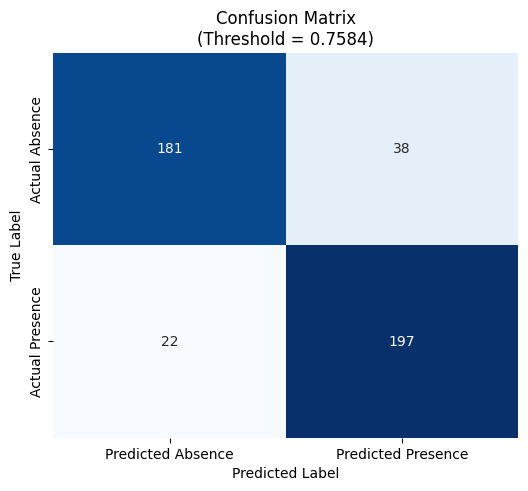


📊 DETAILED PERFORMANCE METRICS
Accuracy:    0.8630  (Overall correctness)
Sensitivity: 0.8995  (Ability to find Avocado)
Specificity: 0.8265  (Ability to ignore background)
------------------------------
Full Classification Report:
              precision    recall  f1-score   support

     Absence       0.89      0.83      0.86       219
    Presence       0.84      0.90      0.87       219

    accuracy                           0.86       438
   macro avg       0.86      0.86      0.86       438
weighted avg       0.86      0.86      0.86       438



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ---------------------------------------------------------
# 1. FIND OPTIMAL THRESHOLD (Youden's Index)
# ---------------------------------------------------------
# fpr and tpr were calculated in the previous step
# Youden's J = Sensitivity + Specificity - 1
# equivalent to: TPR - FPR
j_scores = tpr - fpr
best_index = np.argmax(j_scores)

# Use the thresholds from roc_curve (we need to re-run roc_curve to get thresholds output)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"✅ Optimal Threshold calculated: {optimal_threshold:.4f}")

# ---------------------------------------------------------
# 2. GENERATE CONFUSION MATRIX
# ---------------------------------------------------------
# Convert probabilities to 0 or 1 based on the threshold
y_pred_binary = [1 if p >= optimal_threshold else 0 for p in y_scores]

# Create Matrix
cm = confusion_matrix(y_true, y_pred_binary)

# ---------------------------------------------------------
# 3. VISUALIZE HEATMAP
# ---------------------------------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Absence', 'Predicted Presence'],
            yticklabels=['Actual Absence', 'Actual Presence'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\n(Threshold = {optimal_threshold:.4f})')
plt.show()

# ---------------------------------------------------------
# 4. PRINT DETAILED METRICS
# ---------------------------------------------------------
# Extract specific values from CM
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) # Recall
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_true, y_pred_binary)

print("\n" + "="*30)
print("📊 DETAILED PERFORMANCE METRICS")
print("="*30)
print(f"Accuracy:    {accuracy:.4f}  (Overall correctness)")
print(f"Sensitivity: {sensitivity:.4f}  (Ability to find Avocado)")
print(f"Specificity: {specificity:.4f}  (Ability to ignore background)")
print("-" * 30)
print("Full Classification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['Absence', 'Presence']))